<a href="https://colab.research.google.com/github/RogerUltimate/-Keras-study/blob/main/image_classification_from_scratch_%EC%A3%BC%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.


## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


In [ ]:
# !를 앞에 붙이면 파이썬이 아닌 OS shell에서 실행됨
# curl: Client URL에서 유래한 말로서 인터넷 상에서 자료를 가져올 때 사용하는 명령어
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   161M      0  0:00:04  0:00:04 --:--:--  165M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls        # ls = list: 현 디렉토리의 파일 목록을 보기 위한 명령어

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [ ]:
!ls PetImages    # PetImages 폴더 밑에 Cat과 Dog 폴더가 생성되었음

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.

파일 헤더에 'JFIF'라는 단어가 없으면 그 파일은 손상되었다고 보고 지워버림. 

JFIF = JPEG File Interchange Format의 약자. 이미지 파일 형식 표준. 

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)   # 폴더 경로와 파일 이름 사이의 '/'는 알아서 넣음
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")       # rb: read binary. 이 파일에서 binary는 2가지 의미로 사용됨. 이진 코드로 쓰인 파일, 이진 분류
            # fobj 파일에서 10 bytes를 읽어온 것 안에 "JFIF"를 bytes로 변환한 것이 있으면 True
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)    
        finally:                   # try가 먹든 안 먹든 finally 부분은 항상 실행됨
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


## Generate a `Dataset`


In [ ]:
# image_dataset_from_directory의 기능: 디렉토리에 있는 이미지 파일들로부터 Dataset을 만들어냄.
# --> 참고: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
# (PetImages 폴더 밑에 있는 Cat 폴더, Dog 폴더의 이미지 파일들로부터~)

# Dataset은 keras에서 데이터의 특수한 한 형태로서, Dataset에서만 사용할 수 있는 메소드들이 있으며,
# 이들을 사용하여 데이터 로딩 시간을 줄여서 학습시간을 줄임
# (cache(), shuffle(), batch(), prefetch() 등등)
# --> 참고: https://www.facebook.com/groups/TensorFlowKR/permalink/911745229166536/

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(       # Cat, Dog 폴더 자체를 class로 인식함
    "PetImages",
    validation_split=0.2,
    subset="training",       # validation_split을 0.2로 하는데, 이번 것은 학습 셋이다
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,   # Dataset 중에서도 BatchDataset이 만들어짐
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",      # 이번 것은 val 셋이다
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


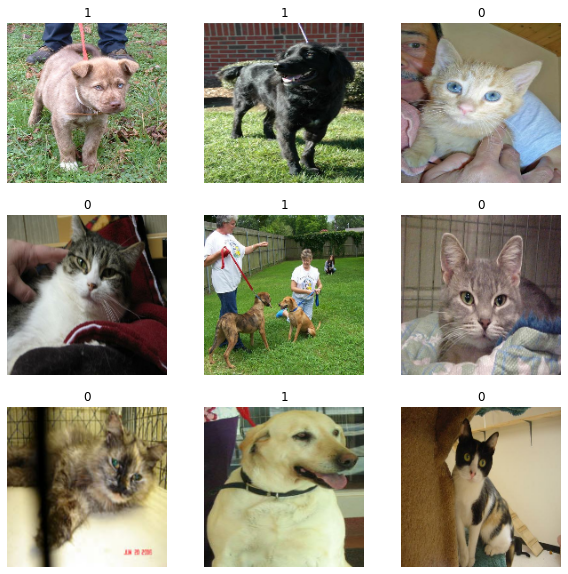

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):     # 각 샘플은 이미지와 레이블로 구성되어 있음을 알 수 있음
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [ ]:
# 참고: Dataset의 데이터 꺼내보기
i = 0
for i, element in enumerate(train_ds.as_numpy_iterator()):
    if i == 0:
        print(element[0][0][0])
        i += 1
    else:
        break

[[118.106476   24.106482   48.106483 ]
 [119.166664   25.166666   49.166668 ]
 [117.92593    23.925926   47.925926 ]
 [117.13426    23.13426    47.134262 ]
 [112.         18.         42.       ]
 [110.083336   16.083334   40.083332 ]
 [112.55556    14.555555   39.555557 ]
 [116.40277    18.402777   43.402775 ]
 [119.53241    21.532406   46.532406 ]
 [119.111115   21.111113   46.111115 ]
 [121.30556    23.305555   48.305553 ]
 [115.46297    20.462969   44.462967 ]
 [110.89815    16.898148   40.898148 ]
 [113.458336   18.458334   42.458332 ]
 [115.23148    17.898157   42.675934 ]
 [121.03703    21.037031   47.037033 ]
 [123.625      23.625      49.625    ]
 [120.236115   22.569445   47.458332 ]
 [114.33334    19.333344   43.333344 ]
 [110.791664   15.791661   39.79166  ]
 [113.         18.         42.       ]
 [114.44444    19.444443   43.444443 ]
 [121.54166    26.541656   50.541656 ]
 [124.80093    29.800924   53.800926 ]
 [123.25462    28.254627   52.254627 ]
 [118.6389     23.6389   

## Using image data augmentation 이미지 데이타 증식시키기

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),   # 수평 방향으로 뒤집기
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)  # 움직이기: height_factor, width_factor
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


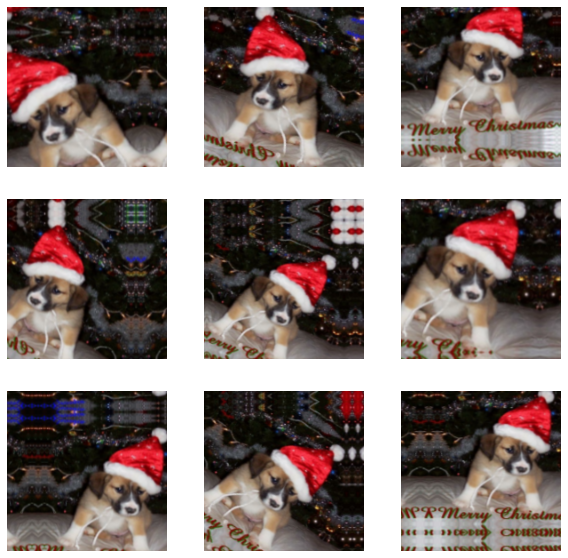

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))    
        plt.axis("off")

## Standardizing the data 데이터 표준화

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

데이터 증가(data_augmentation) 전처리 함수를 사용하는 2가지 방법

**Option 1: Make it part of the model**, like this:

첫번째 방법: 모델의 일부로 넣어서 사용

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

데이터 증가 함수인 data augmentation이 모델 학습과 동시에 실행되므로, 연산능력이 좋은 경우(GPU가 있는 경우) 유리함. 데이터 증가는 fit에서만 작동하며, evaluate이나 테스트에서는 작동하지 않음

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

두번째 방법: dataset에 함수를 적용하여 새로운 dataset을 만들어 냄

```python
# 첫번째 원소인 이미지를 augment
# training=True ??
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

모델 학습 이전에 data augmentation이 실행되므로, 연산능력이 부족한 경우(CPU) 적절

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.

본 사례에서는 첫번째 방법을 사용하겠음


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:
# prefetch는 현재의 element가 처리되는 동안 이후에 처리할 일정량의 element를 추가 메모리에
# 준비(예를 들면, 읽고 전처리)해 둠
# buffer_size는 prefetch할 원소의 갯수. 보통은 1로 해도 충분
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

여기서는 Xception 네트워크의 작은 버전을 만들어 보겠음(Xception 자체를 만드는 것이 아니고, Xception 알고리즘의 특징인 depthwise SeperableConv를 사용)

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


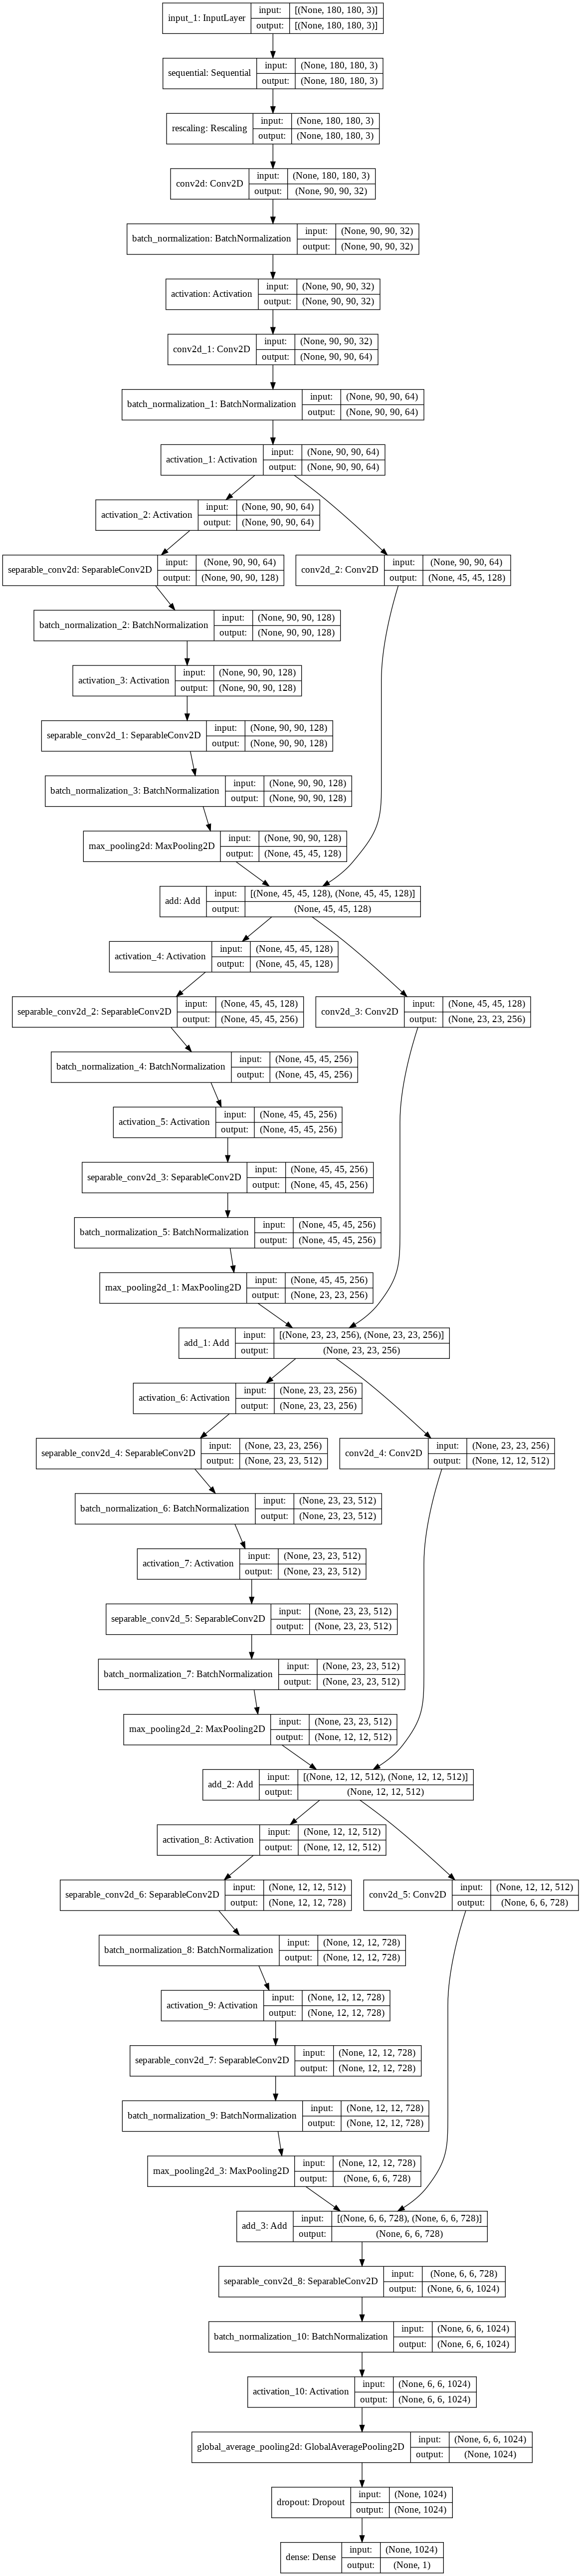

In [ ]:
# 본 모델은 SeperableConv2D(=depthwise seperable convolution)와 pointwise convolution(strides=2)를 합침
# 참고: https://arxiv.org/abs/1610.02357 (pdf를 다운받을 것)
# 아래에서 keras.utils.plot_model(model, show_shapes=True)을 실행한 결과 그림을 먼저 보면 구조를 이해하기 쉬움
# SeperableConv2D = depthwise convolution + pointwise convolution(strides=1)의 2개 부분으로 구성됨(겉으로 보이지 않음)
# depthwise convolutin < depthwise seperable convolution 
# depth는 channel 갯수를 의미. 컬러라면 3. 데이터가 convolution layer를 거치면 필터 갯수만큼의 channel 갯수가 생겨남
# 참고: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728 
# 참고 사이트에서 설명하고 있는 방식은 MobileNet 방식으로 depthwise seperable convolution만 하고 있음 

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)     # 평균 0, 표준편차 1. 오버피팅을 줄임
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Set aside residual: 현재의 x값을 저장해 둠
    previous_block_activation = x  

    # (3, 3) 크기의 필터를 이용한 SeparableConv2D
    # for 문의 첫번째 숫자인 필터 갯수 128로 해서 실행시키고, 그 결과를 
    # '앞서 저장해 둔 previous_block_activation을 pointwise conv한 것'과 합침
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # 앞서 저장해 둔 x값, 즉 previous_block_activation에 대해 (1, 1) 크기의 필터를 이용한 
        # pointwise conv를 실행
        # strides=2인 것이 특이함
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )

        # depthwise conv 결과와 pointwise conv 결과를 합쳐서 다시 previous_block_activation으로 저장해 둠
        # 이렇게 저장한 값은 for문에 의하여 다음의 필터 갯수 256이 실행될 때 입력값으로 사용됨. 
        # 이 과정이 for 문에 의해 반복됨
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)   # H, W를 모두 1로 줄임(숫자 하나)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)    # Dataset 생성할 때 image_size = (180, 180)로 잡았음
keras.utils.plot_model(model, show_shapes=True)   # 이 메소드 매우 유용함


## Train the model


In [ ]:
epochs = 3   # 원래 50 epochs로 되어 있으나 시간이 오래 걸려서 세번만 실행시킴. 5분 54초 소요

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),   # 매 에포크마다 파일 저장하는 법
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/3
586/586 [==============================] - 131s 192ms/step - loss: 0.6749 - accuracy: 0.6237 - val_loss: 0.7088 - val_accuracy: 0.5805


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
586/586 [==============================] - 111s 190ms/step - loss: 0.5848 - accuracy: 0.6966 - val_loss: 0.7606 - val_accuracy: 0.6568
Epoch 3/3
586/586 [==============================] - 111s 190ms/step - loss: 0.4995 - accuracy: 0.7580 - val_loss: 0.4223 - val_accuracy: 0.8133


We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data 새로운 데이터로 예측하기

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


This image is 99.94 percent cat and 0.06 percent dog.


# Option 2 이미지를 미리 augment하여 새로운 데이터셋 생성

In [ ]:
# 첫번째 원소인 이미지를 augment
# training=True : 지금은 학습을 할 것이니 data augmentation을 실행하라는 의미. 예측 모드에서는 실행 않음
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

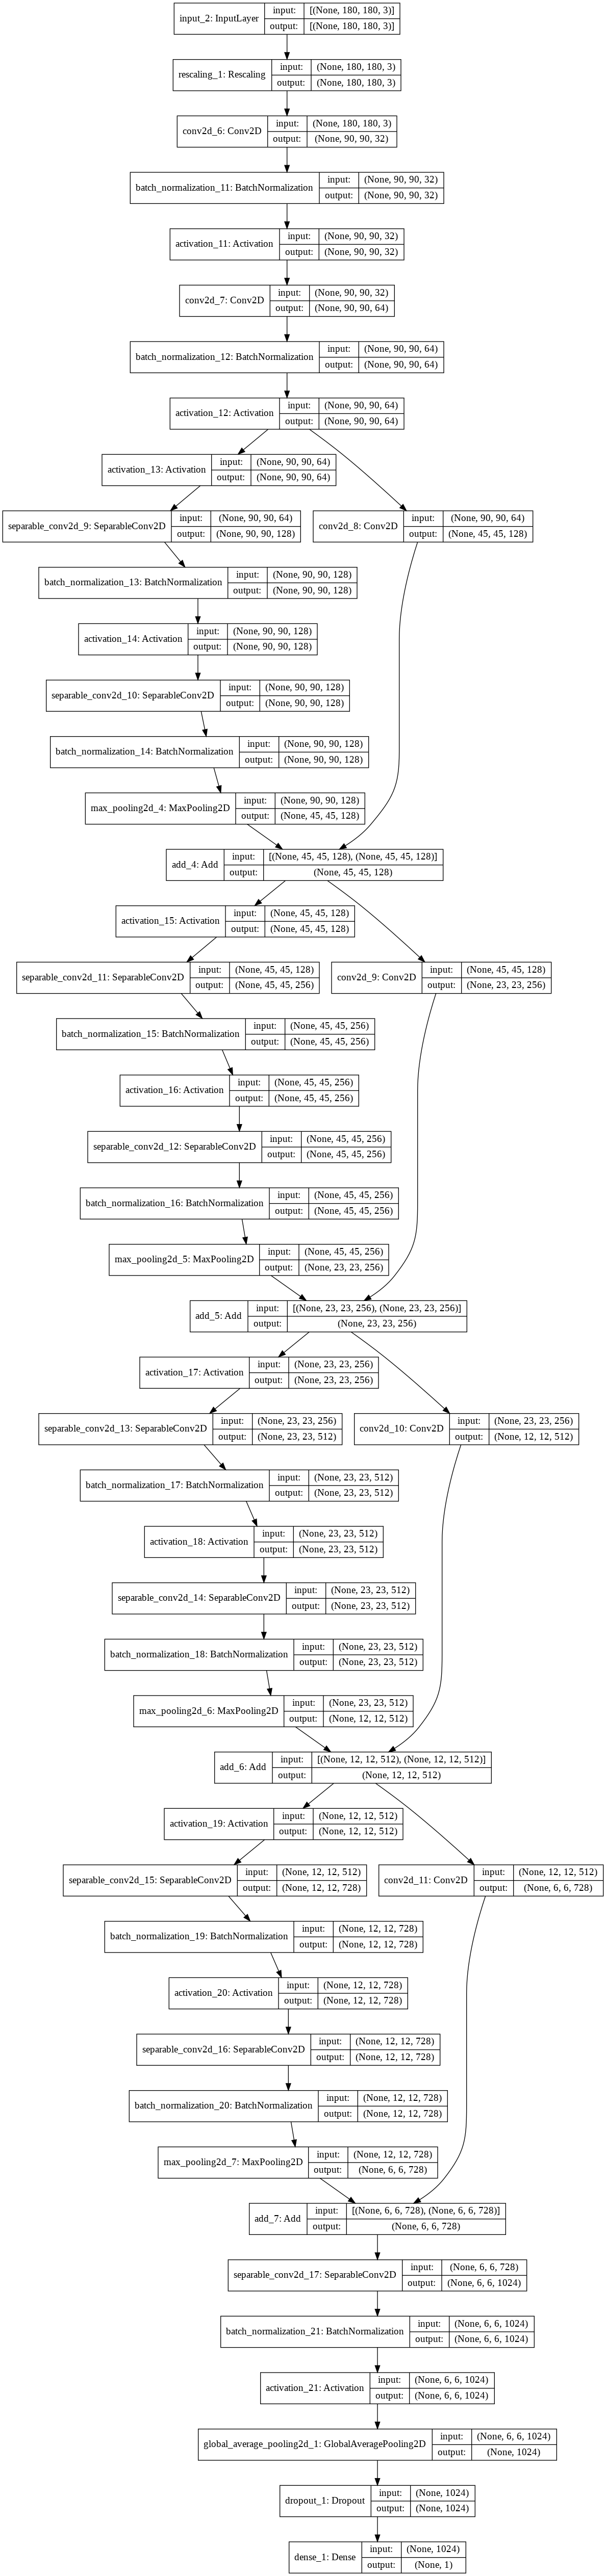

In [ ]:
def make_model2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)     # 평균 0, 표준편차 1. 오버피팅을 줄임
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Set aside residual: 현재의 x값을 저장해 둠
    previous_block_activation = x  

    # (3, 3) 크기의 필터를 이용한 SeparableConv2D
    # for 문의 첫번째 숫자인 필터 갯수 128로 해서 실행시키고, 그 결과를 
    # '앞서 저장해 둔 previous_block_activation을 pointwise conv한 것'과 합침
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # 앞서 저장해 둔 x값, 즉 previous_block_activation에 대해 (1, 1) 크기의 필터를 이용한 
        # pointwise conv를 실행
        # strides=2인 것이 특이함
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )

        # depthwise conv 결과와 pointwise conv 결과를 합쳐서 다시 previous_block_activation으로 저장해 둠
        # 이렇게 저장한 값은 for문에 의하여 다음의 필터 갯수 256이 실행될 때 입력값으로 사용됨. 
        # 이 과정이 for 문에 의해 반복됨
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)   # H, W를 모두 1로 줄임(숫자 하나)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model2 = make_model2(input_shape=image_size + (3,), num_classes=2)    # image_size + (3,)
keras.utils.plot_model(model2, show_shapes=True)   # 이 메소드 매우 유용함


In [ ]:
epochs = 3   # 원래 50 epochs로 되어 있으나 시간이 오래 걸려서 세번만 실행시킴. 3 epoch에 10분 19초 소요

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),   # 매 에포크마다 파일 저장하는 법
]
model2.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model2.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/3
586/586 [==============================] - 213s 334ms/step - loss: 0.6737 - accuracy: 0.6202 - val_loss: 0.6716 - val_accuracy: 0.6025


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
586/586 [==============================] - 203s 346ms/step - loss: 0.5625 - accuracy: 0.7163 - val_loss: 0.5732 - val_accuracy: 0.7006
Epoch 3/3
586/586 [==============================] - 203s 346ms/step - loss: 0.4838 - accuracy: 0.7704 - val_loss: 0.5436 - val_accuracy: 0.7518


# Option 3 이미지 augmentation을 사용하지 않기

위 Option 2에서 첫번째 셀의 data augmentation만 실행하지 않으며, 나머지는 동일함

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

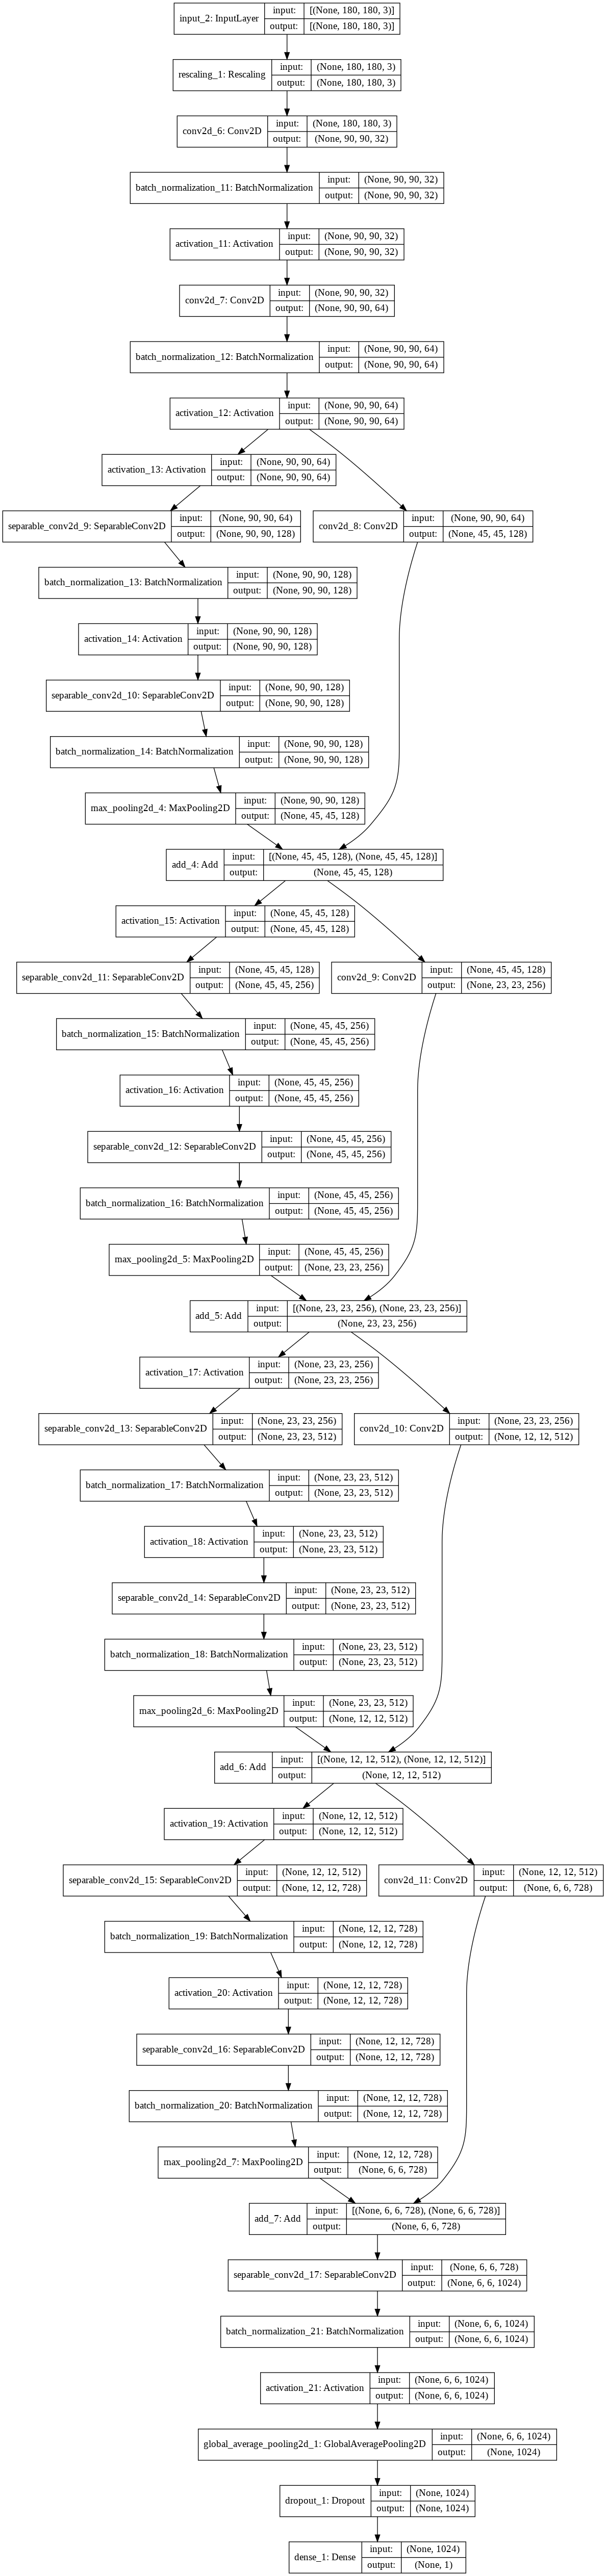

In [ ]:
def make_model3(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)     # 평균 0, 표준편차 1. 오버피팅을 줄임
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Set aside residual: 현재의 x값을 저장해 둠
    previous_block_activation = x  

    # (3, 3) 크기의 필터를 이용한 SeparableConv2D
    # for 문의 첫번째 숫자인 필터 갯수 128로 해서 실행시키고, 그 결과를 
    # '앞서 저장해 둔 previous_block_activation을 pointwise conv한 것'과 합침
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # 앞서 저장해 둔 x값, 즉 previous_block_activation에 대해 (1, 1) 크기의 필터를 이용한 
        # pointwise conv를 실행
        # strides=2인 것이 특이함
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )

        # depthwise conv 결과와 pointwise conv 결과를 합쳐서 다시 previous_block_activation으로 저장해 둠
        # 이렇게 저장한 값은 for문에 의하여 다음의 필터 갯수 256이 실행될 때 입력값으로 사용됨. 
        # 이 과정이 for 문에 의해 반복됨
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)   # H, W를 모두 1로 줄임(숫자 하나)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model3 = make_model3(input_shape=image_size + (3,), num_classes=2)    # Dataset 생성할 때 image_size = (180, 180)로 잡았음
keras.utils.plot_model(model3, show_shapes=True)   # 이 메소드 매우 유용함


In [ ]:
epochs = 3   # 원래 50 epochs로 되어 있으나 시간이 오래 걸려서 세번만 실행시킴. 3 epoch에 5분 38초 소요

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),   # 매 에포크마다 파일 저장하는 법
]
model3.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model3.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/3
586/586 [==============================] - 125s 183ms/step - loss: 0.5963 - accuracy: 0.6913 - val_loss: 0.9522 - val_accuracy: 0.5152


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/3
586/586 [==============================] - 106s 181ms/step - loss: 0.3988 - accuracy: 0.8210 - val_loss: 0.4021 - val_accuracy: 0.8234
Epoch 3/3
586/586 [==============================] - 106s 181ms/step - loss: 0.2796 - accuracy: 0.8817 - val_loss: 0.5290 - val_accuracy: 0.8097
